# Entrega 2

## Ejercicio 1

### a. ¿Que situacion se representa con una variable aleatoria geometrica?

Usamos una variable aleatoria geométrica para modelar el número de intentos necesarios hasta llegar al primer éxito en ensayos de Bernoulli independientes y con probabilidad constante de éxito $\theta$

Algunos ejemplos son:
- Lanzamientos de una moneda
- Control de Calidad
- y muchos mas

### b. Derivar la distribucion posterior para $\theta$ suponiendo que se observó Y = y. Identificar la distribución encontrada y sus parámetros.

Sabemos:
1. Prior ∼ Beta(a, b)
2. Likelihood: $P(Y = y∣\theta) = \theta(1 - \theta)^{y-1}$
3. Posterior: Multiplicamos el Prior por la Likelihood y normalizamos:
    - $\theta ∣ Y = y ∼ Beta(a + 1, b + y - 1)$

### c. ¿El modelo Beta es un prior conjugado de la Geométrica?

Si, pues el Prior y el Posterior pertenecen al mismo tipo de distribuciones (Beta)

---

Bis: Ejemplo (para mi) para fijar mejor las ideas:

Supongamos un juego de donde se debe lanzar un dado y se gana al sacar un "6". Se quiere estimar la probabilidad $\theta$ de ganar en un solo lanzamiento. 

Supongo que es dificil sacar ese "6", pero no estoy seguro y quiero actualizar mi creencia luego de cada lanzamiento.

Entonces:
- Variable aleatoria Y: Numero de lanzamientos hasta sacar el "6".
- Distr Geometrica: $P(Y = y∣\theta) = \theta(1 - \theta)^{y-1}$
- Prior Beta: Empezamos de forma pesimista sobre sacar un "6". a = 2, b = 10.

Observacion:

Imagino que juego el juego, y el primer "6" aparece en mi 5to lanzamiento. Y = 5.

Actualizacion:

- Likelihood: Y = 5 con lo que:  $\theta (1 - \theta)^{4}$
- Posterior: Posterior $\alpha$ Prior * Likelihood = Beta(2, 10) * $\theta (1 - \theta)^{4}$
        - Es decir: Post $\alpha$ $\theta^{2 + 1}(1 - \theta)^{10 + 4 - 1}$ = $\theta^{3}(1 - \theta)^{13}$

Esto significa que el Post tambien es Beta. Pues Post = Beta(3, 13)

---

## Ejercicio 2

Elijo como modelo de Regresion Lineal el precio de la comida y la propina dejada.

Obtenemos nuestros datos:

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

from scipy.stats import gamma, norm
from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño

In [34]:
datos = sns.load_dataset('tips')

# Para no perder el contexto de los tips, vamos a quedarnos con los platos >= 20 usd
datos["total_bill"] = datos["total_bill"] - 20
datos_filtrados = datos[datos["total_bill"] >= 0]
datos_filtrados

,total_bill,tip,sex,smoker,day,time,size
2,1.01,3.50,Male,No,Sun,Dinner,3
3,3.68,3.31,Male,No,Sun,Dinner,2
4,4.59,3.61,Female,No,Sun,Dinner,4
5,5.29,4.71,Male,No,Sun,Dinner,4
7,6.88,3.12,Male,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
237,12.83,1.17,Male,Yes,Sat,Dinner,2
238,15.83,4.67,Female,No,Sat,Dinner,3
239,9.03,5.92,Male,No,Sat,Dinner,3
240,7.18,2.00,Female,Yes,Sat,Dinner,2


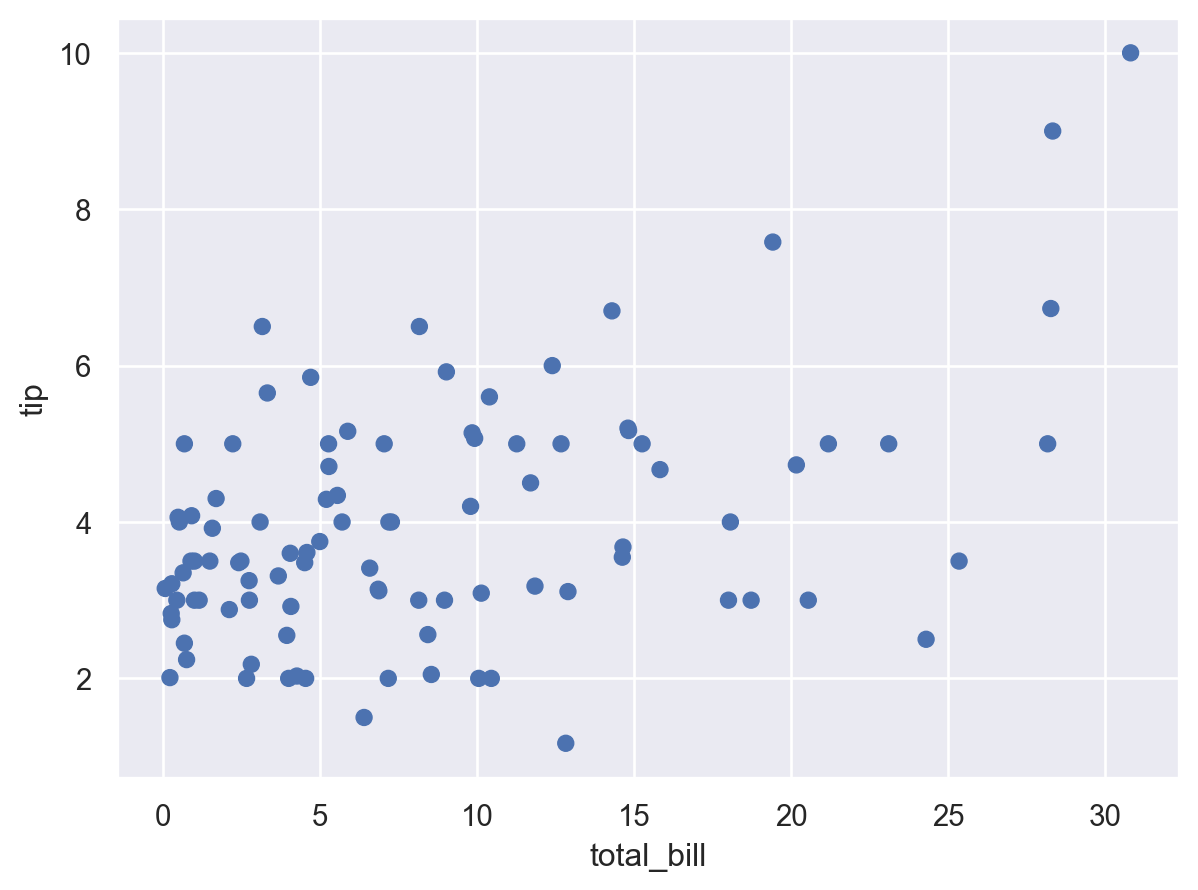

In [35]:
(
    so.Plot(data=datos_filtrados, x='total_bill', y='tip')
    .add(so.Dot())
)


### a. Proponer priors para $\beta_0$, $\beta_1$ y $\sigma $

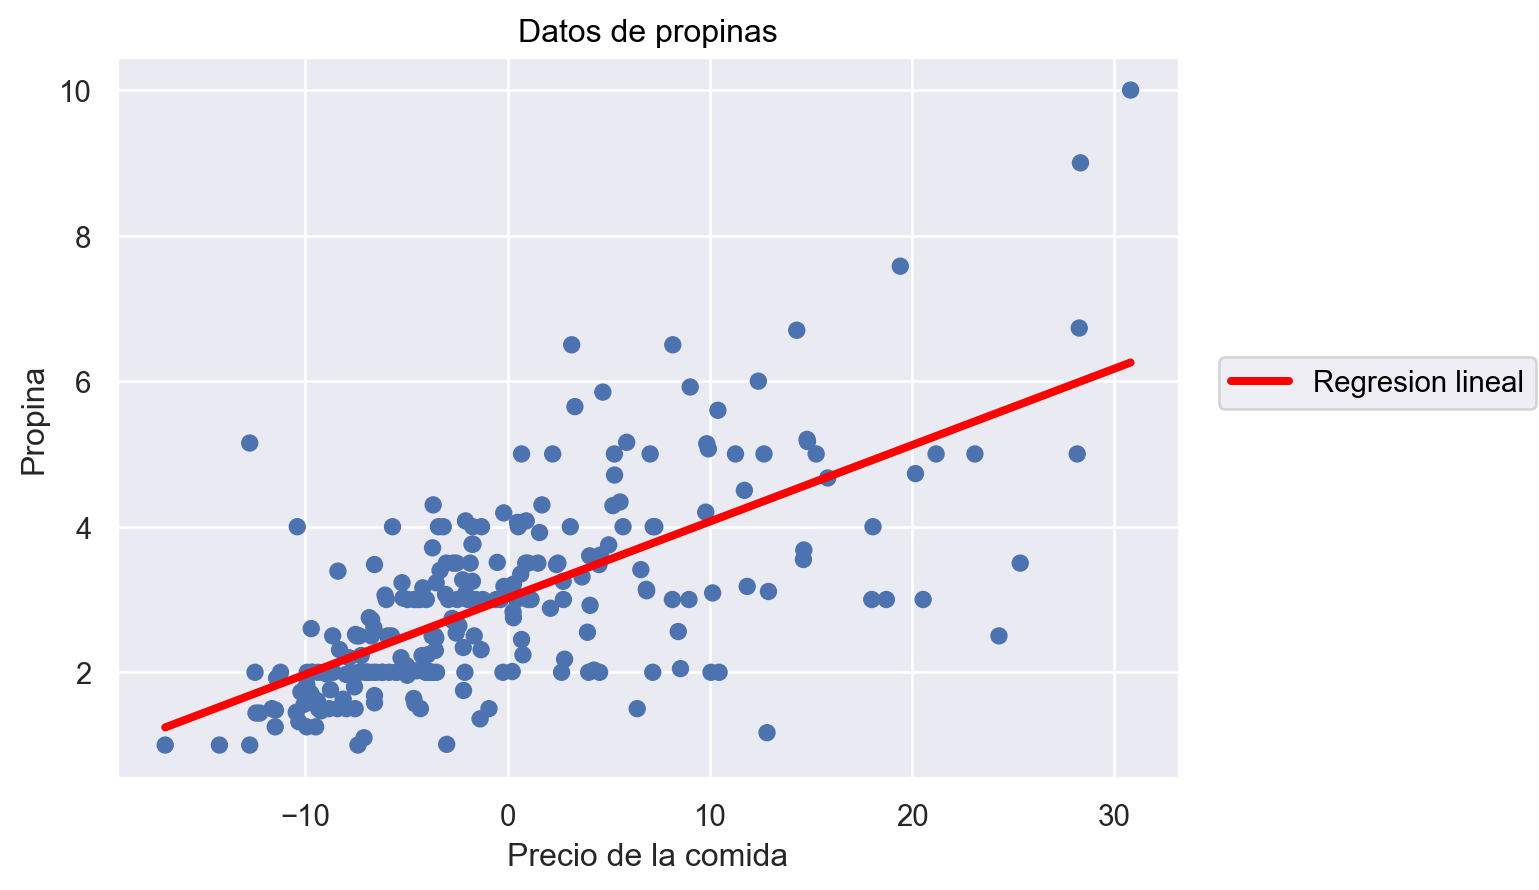

In [30]:
(
    so.Plot(data=datos, x='total_bill', y='tip')
    .add(so.Dot())
    .add(so.Line(color="red", linewidth=3), so.PolyFit(1), label='Regresion lineal')  
    .label(title='Datos de propinas', x='Precio de la comida', y='Propina')   
)


Uno pensaria que cuanto mas cara la comida, mayor es la propina (el conocido 10%)

Entonces decido elegir un caso individual:
- Una comida que cueste 20 usd
- Su propina debe rondar por los 2 usd.
- Estimemos tambien un desvio estandar de 0.5usd

Con lo que obtenemos que:
- $\mu$ = 2usd
- $\sigma$ = 0.5usd

Entonces 
- $\mu$ = $\frac{\alpha}{\beta}$
- $\sigma^2$ = $(\frac{\alpha}{\beta})^2$

Obtenemos asi que:

- $\alpha$ = 16
- $\beta$ = 8

Con lo que definimos que nuestros datos se comportan con una distribucion:

- $Gamma(\alpha = 16, \beta = 8)$

In [42]:
alpha_inicial = 16
beta_inicial = 8 
iteraciones = 1000
tips_hipotesis = datos_filtrados["tip"].values
tips_hipotesis

array([ 3.5 ,  3.31,  3.61,  4.71,  3.12,  5.  ,  3.92,  3.35,  2.75,
        7.58,  4.3 ,  2.45,  3.6 ,  5.  ,  5.6 ,  5.  ,  6.  ,  2.05,
        5.2 ,  4.34,  3.  ,  1.5 ,  6.73,  3.21,  3.15,  2.01,  3.14,
        5.  ,  4.  ,  3.  ,  5.  ,  5.17,  5.85,  3.  ,  3.  ,  3.5 ,
        3.25,  4.73,  4.  ,  3.  ,  2.5 ,  3.48,  4.08,  4.06,  4.29,
        4.  ,  2.55,  4.  ,  5.07,  2.92,  4.2 ,  2.18,  2.83,  6.7 ,
        5.  ,  5.  ,  2.  ,  5.14,  5.  ,  3.75,  3.5 ,  3.48,  2.24,
        4.5 , 10.  ,  3.18,  3.11,  3.55,  3.68,  5.65,  3.5 ,  6.5 ,
        3.  ,  5.  ,  3.5 ,  2.  ,  4.  ,  2.56,  5.  ,  4.  ,  3.41,
        3.  ,  2.03,  2.  ,  5.16,  9.  ,  6.5 ,  3.  ,  3.09,  3.  ,
        2.88,  2.  ,  1.17,  4.67,  5.92,  2.  ,  2.  ])

#### Definimos la likelihood

In [43]:
# Definir una función de likelihood para los datos dados.
def log_likelihood(alpha, beta, datos):
    return np.sum(gamma.logpdf(datos, a = alpha, scale=1/beta)) # scale = 1/ tasa, donde tasa = beta.

# El likelihood de una Gamma es el producto de las densidades de probabilidad individuales para cada valor observado.
# np.sum(gamma.logpdf(datos, a = alpha, scale=1/beta)) calcula la suma de los logaritmos de densidades de probabilidad
# para cada dato en "datos" bajo una distr Gamma.

#### Definimos MCMC

In [55]:
def mcmc(datos, alpha_inicial, beta_inicial, iteraciones, sigma_alpha = 0.5, sigma_beta = 0.5):
    cadena_alpha = [alpha_inicial]
    cadena_beta = [beta_inicial]

    for i in range(iteraciones):
        # Proponer nuevos valores para alpha y beta (muestreo normal centrado en el valor actual de sigma).
        nuevo_alpha = np.abs(norm(cadena_alpha[-1], sigma_alpha).rvs())     
        nuevo_beta = np.abs(norm(cadena_beta[-1], sigma_beta).rvs())
        #.rvs() genera una muestra aleatoria de la distr normal creada anteriormente.

        # Calcular los likelihood.
        log_likelihood_actual = log_likelihood(cadena_alpha[-1], cadena_beta[-1], datos)
        log_likelihood_nuevo = log_likelihood(nuevo_alpha, nuevo_beta, datos)

        # Aceptar siempre si la nueva verosimilitud es mayor (mejor propuesta).
        if log_likelihood_nuevo > log_likelihood_actual:
            cadena_alpha.append(nuevo_alpha)
            cadena_beta.append(nuevo_beta)

        # Si la nueva verosimilitud es menor, aceptamos con probabilidad basada en la diferencia de verosimilitudes.
        # Aceptamos la propuesta fijandonos que tan "peor" es comparado a la actual (por eso "probabilidad_aceptacion").
        else:
            # "probabilidad_aceptacion": La razon de likelihoods entre la nueva y la actual
            probabilidad_aceptacion = np.exp(log_likelihood_nuevo - log_likelihood_actual)
            
            if np.random.rand() < probabilidad_aceptacion:
                cadena_alpha.append(nuevo_alpha)
                cadena_beta.append(nuevo_beta)
            else:
                cadena_alpha.append(cadena_alpha[-1])
                cadena_beta.append(cadena_beta[-1])
    
    return np.array(cadena_alpha), np.array(cadena_beta)


In [58]:
# Ejecutar el MCMC usando las propinas reales observadas
cadena_alpha, cadena_beta = mcmc(tips_hipotesis, alpha_inicial, beta_inicial, iteraciones)

In [59]:
# Mostrar los últimos valores de la cadena
print("Últimos valores de la cadena:")
print(f"alpha: {cadena_alpha[-5:]}")
print(f"beta: {cadena_beta[-5:]}")

Últimos valores de la cadena:
alpha: [8.13812876 8.13812876 8.13812876 8.13812876 7.62829082]
beta: [2.08798336 2.08798336 2.08798336 2.08798336 1.88302367]


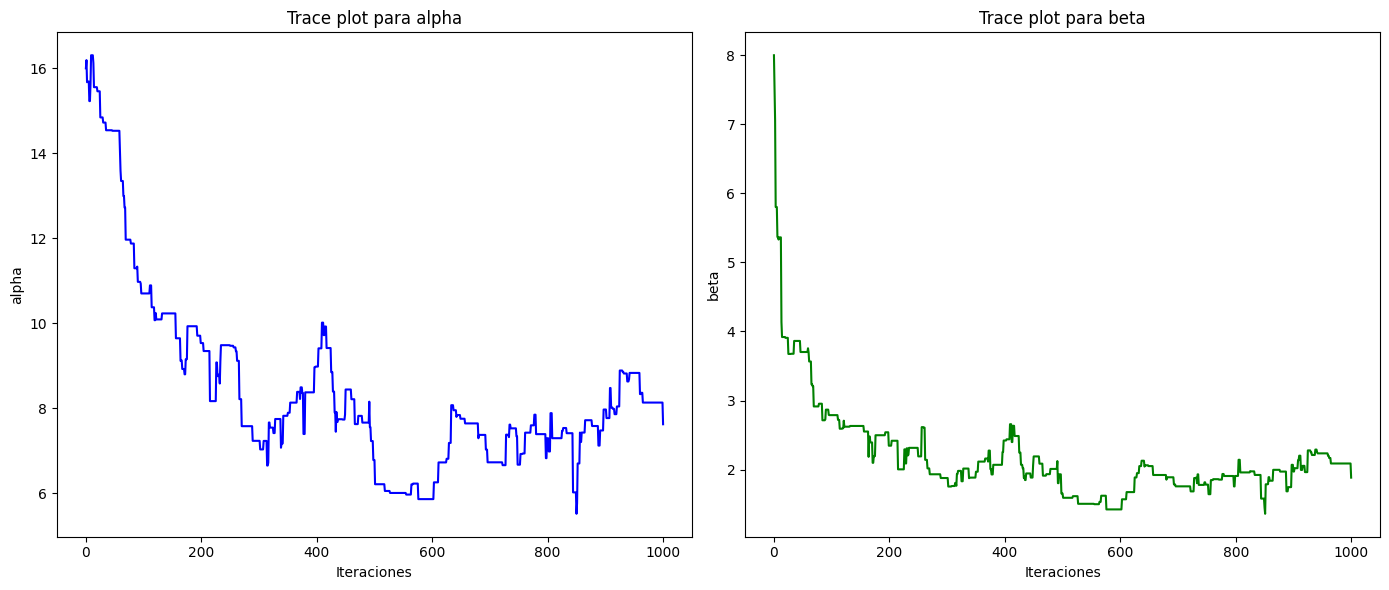

<Figure size 1400x600 with 0 Axes>

In [64]:
# Asumimos que ya tenemos las cadenas "cadena_alpha" y "cadena_beta" después de ejecutar el MCMC

# Trazas de la cadena para alpha y beta
plt.figure(figsize=(14, 6))

# alpha
plt.subplot(1, 2, 1)
plt.plot(cadena_alpha, color='blue')
plt.title("Trace plot para alpha")
plt.xlabel("Iteraciones")
plt.ylabel("alpha")

# beta
plt.subplot(1, 2, 2)
plt.plot(cadena_beta, color='green')
plt.title("Trace plot para beta")
plt.xlabel("Iteraciones")
plt.ylabel("beta")

plt.tight_layout()
plt.show()

# Histogramas para alpha y beta
plt.figure(figsize=(14, 6))

plt.tight_layout()
plt.show()
